# Introduction

Data Science is becoming an increasingly important job. In a data abundant world being able to extract knowledge from data will be became a competitive necessity. In this sense, companies around the world are investing more and more in their data science teams. According to a 2012 article from [Havard Business Review](https://hbr.org/2012/10/data-scientist-the-sexiest-job-of-the-21st-century) data science will is the most promissing job for the 21st century. In this notebook we will analyse the evolution in the number of data scientists along the years. For this purpose we will be using the data from Stack Overflow Survey from 2017 to 2020.

First loading the required packages and setting up ploting configurations

In [52]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from typing import Any
import seaborn as sns

sns.set(context='notebook', style='whitegrid', font_scale=1)

# Loading the Data

To answer the first question we will be using the data from the surveys from 2017 to 2020. For each year we will load the dataset from the respective year and select the column respective to the question relative to developer type. In this question the respondents select multiple type of developers that bets describe them. We will then remove missing rows from this variable. We then get the percentage of valid answers that checked options that contained 'Data scientist' or 'Machine learning'.

In [6]:
# loading devtype data from years 2017 to 2020
def load_devtype_answers(file_path: str) -> pd.Series:
    """Loading data of Dev Type answers only works for the data from
    2017 onwards. Select the column name based on the year and only load its
    data into a pd.Series. Remove missing data and return the series.
    """
    
    col = 'DevType' if year > 2017 else 'DeveloperType' # selecting col name according to year
    df = pd.read_csv(file_path, usecols=[col])    # only loading data from the selected col
    devtype_answers = df[col]
    devtype_answers.dropna(inplace=True) # removing missing data
    return devtype_answers

In [7]:
data_folder = 'data'
file_name_suffix = '_data.zip'
devtype_answers = dict()
for year in range(2017, 2021):
    file_name = str(year) + file_name_suffix
    file_path = os.path.join(data_folder, file_name)
    data = load_devtype_answers(file_path)
    devtype_answers[year] = data

For each year the respondents had a number of options that could be selected. It was possibile to select more than one answer. Those options are separated in the data by '; ' (for the 2017 year) or ';' (other years). Depending on the years different options were available for the respondents to select. Bellow we are printing a sample of the data for each year and the list of unique options available for each year.

In [18]:
for year, data in devtype_answers.items():
    print(f'Sample of developer type answer for the {year} Stack Overflow Survey.', '\n')
    print(data.sample(5), '\n')
    unique_options = data.str.split(';').explode().str.strip().unique()
    print(f'{unique_options.size} unique options:')
    print(unique_options)
    print('#'*70, '\n'*2)

Sample of developer type answer for the 2017 Stack Overflow Survey. 

13939    Graphics programming; Desktop applications dev...
850                Embedded applications/devices developer
43475    Web developer; Mobile developer; Graphics prog...
750                                          Web developer
4875                                         Web developer
Name: DeveloperType, dtype: object 

14 unique options:
['Other' 'Mobile developer' 'Graphics programming'
 'Desktop applications developer' 'Web developer'
 'Embedded applications/devices developer' 'DevOps specialist'
 'Quality assurance engineer' 'Data scientist'
 'Machine learning specialist'
 'Developer with a statistics or mathematics background'
 'Database administrator' 'Systems administrator' 'Graphic designer']
###################################################################### 


Sample of developer type answer for the 2018 Stack Overflow Survey. 

4923     Front-end developer;Full-stack developer;QA or...
54489  

# The evolution of the share of Data Scientists

From those options above, we can attribute to data scientists profession 'Data scientist' and 'Machine learning specialist' from the 2017 survey, and 'Data scientist or machine learning specialist' from all the other surveys. We can identify data scientsts by selecting all the respondents that have in their answers the string 'Data scientists' or 'Machine learning'.

In [19]:
def gen_ds_percent(devtype: pd.Series) -> float:
    """This function calculates the percentage of respondentents that
    consider itself as being Data Scientists. In 2017 the Data Scientists and
    Machine Learning Specialist were two different options. From 2018, those
    were integrated into a single option. In order to match both cases we will
    be using two diferent conditionals to select Data Scientists.
    """    
    
    ds = devtype.str.contains('Data scientist')
    ml = devtype.str.contains('Machine learning')
    is_data_scientist = ds | ml
    return is_data_scientist.mean()

In [21]:
# calculating the percentages that are data scientistis
ds_percentages = {year: gen_ds_percent(data)
                  for year, data in devtype_answers.items()}
ds_percentages

{2017: 0.09951557093425606,
 2018: 0.07696149753523421,
 2019: 0.07942460195487798,
 2020: 0.08077780028357302}

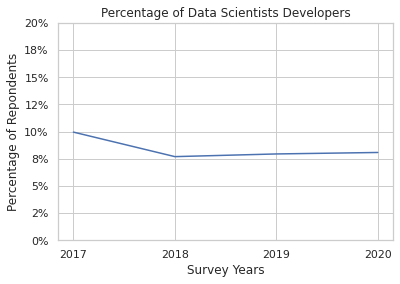

In [35]:
plot_data = pd.Series(ds_percentages)

ax = plot_data.plot()
plt.ylim(0, .2)
plt.xticks(plot_data.index)
ax.yaxis.set_major_formatter(lambda x, p: f'{x:.0%}')
plt.xlabel('Survey Years')
plt.ylabel('Percentage of Repondents')
plt.title('Percentage of Data Scientists Developers')
plt.show()

In [39]:
obs_diff = ds_percentages[2020] - ds_percentages[2017]
print(f'{obs_diff:.2%}')

-1.87%


# Hypotesis Testintg: testing the statistical significance of the change

As it can be seen from the figure above, from 2017 to 2020 there was a small reducion (-1.87 p.p.) in the percentage of data scientists. This sample result is a strong evidence against our initial hypothesis that there is a rise in the number of data scientistis.
But that result must be further studied. We can test if this oserved difference is statistically significant. But first, we must change our initial hypothesis. Instead of testing if there was a rise from to 2017 to 2020 we will be more conservative and test if there was a change. In this sense we can construct our testing hypothesis as such:

$$H_0: \mu_{2020} = \mu_{2017} $$
$$H_1: \mu_{2020} \neq \mu_{2017} $$

To prove that there is a statistically significant difference between 2020 and 2017 (our $H_1$ hypothesis) we will be making $10.000$ bootstrap replicates for the percentage of datas scientists for both years and then take their difference. After this we will compute the p-value of our observed difference and see if the difference is significant at a 5% significance level.

In [41]:
def bootstrap(data: pd.Series, n=10000) -> np.array:
    """Function to generate our bootstrap samples. The default setting
    is to generate 10.000 replicates. For each iteration it takes a 
    sample with replacement from the series equivalent to the size 
    of the series. From this sample the percentage of data scientists
    estimate is computated and added to the replicate lists. The 
    replicate list is transformed into a numpy array and then it is
    returned as the function output.
    """
    
    sample_size = data.shape[0]
    replicates = []
    for _ in range(n):
        sample = data.sample(sample_size, replace=True)
        replicate = gen_ds_percent(sample)
        replicates.append(replicate)
    return np.array(replicates)

In [42]:
# computing the estimates for each year and then taken their differences.
replicates_2020 = bootstrap(devtype_answers[2020])
replicates_2017 = bootstrap(devtype_answers[2017])

Let us compare both replicates distribution with a boxplot alongside a swarmplot. In order to guarantee a better vizualization of the swarmplot only a small sample of the data will be used. But that will be enought to illustrate the datas distributions.

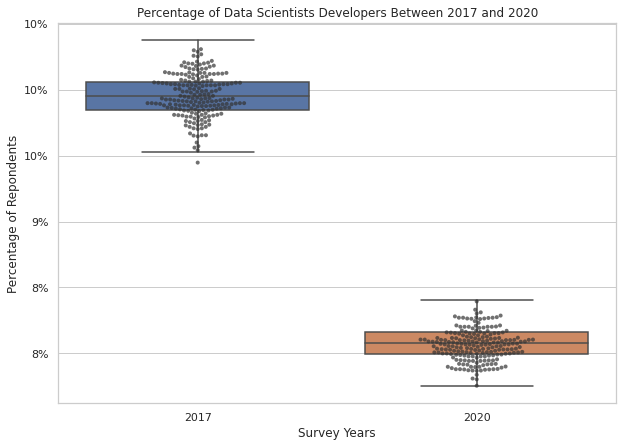

In [43]:
data = np.array([replicates_2017, replicates_2020]).T
columns = [2017, 2020]
plot_data = pd.DataFrame(data=data, columns=columns)
sample_swarm = plot_data.sample(200).melt()

fig = plt.figure(figsize=(10, 7))
ax = sns.boxplot(data=plot_data, showfliers=False)
ax = sns.swarmplot(data=sample_swarm, x='variable', y='value', color='.2', alpha=.7, size=4)
ax.yaxis.set_major_formatter(lambda x, p: f'{x:.0%}')
plt.xlabel('Survey Years')
plt.ylabel('Percentage of Repondents')
plt.title('Percentage of Data Scientists Developers Between 2017 and 2020')
plt.show()

Now let us look up at the distribution of the difference. From the histogram below this distribution seems to be normally distributed. 

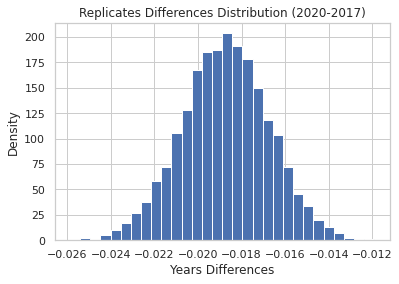

In [51]:
diff_replicates = replicates_2020 - replicates_2017
plt.hist(diff_replicates, density=True, bins=30)
plt.xlabel('Years Differences')
plt.ylabel('Density')
plt.title('Replicates Differences Distribution (2020-2017)')
plt.show()

In [45]:
replicates_mean = diff_replicates.mean()
replicates_std = diff_replicates.std()

replicates_mean, replicates_std

(-0.018752925473842386, 0.0020023463082082947)

In [46]:
replicates_std = diff_replicates.std()
replicates_size = diff_replicates.size
null_mean = 0
null_vals = np.random.normal(null_mean, replicates_std, replicates_size)

Ploting the null hypothesis equivalent distribution

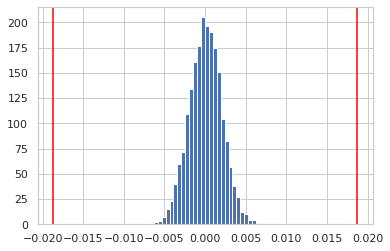

In [47]:
plt.hist(null_vals, density=True, bins=30);
lower_bound = obs_diff
upper_bound = -obs_diff
plt.axvline(lower_bound, color='red')
plt.axvline(upper_bound, color='red');

In [ ]:
p_value = np.mean(null_vals > upper_bound) + np.mean(null_vals < lower_bound)
p_value

In [49]:
size_2017 = devtype_answers[2017].shape[0]
size_2020 = devtype_answers[2020].shape[0]
size_2017, size_2020

(36125, 49370)

Given the estimated p-value of 0, we can reject our null hypotesis that the percentages of data scientsts respondents in 2017 and 2020 are equal. 
Whoever this might have happened as a result of a the large sample that we had in both years.
One limitation of hypotesis testing and confidence intervals is that with a big enough sample, any change could be considered statistically significant.
As the sample size increases the standard deviation of our bootstrap replicates reduces, making it more concentrated aruound the observerd estimate (the expected value).
This reduces our confidence interval, making even small changes statistically significants.
But it is important to keep in mind that statistical signifancy doens't translate automatically into practical significant.
In this sense we can argue that even though a 1.87p.p. reduction from 2017 to 2020 can be statiscally significant, in practical terms it doesn't means much.
As such, even though we data science job is not in the rise anymore, we can't say that is a declining profession.